# Testing Sandbox (CAS)

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import trackpy as tp
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.animation as animation
import os

import tracker
import stats
import visualizer
import utils

import importlib

## Load the Video

In [2]:
videofile = "C:/Users/schmidtc18/Desktop/Python Temp/Obj_Tracking/Frames.avi"

# Visualize the input
cap = cv.VideoCapture(videofile)

# Get the first frame
ret, frame = cap.read()

print(frame.shape)

plt.imshow(frame); plt.show()

gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
mid_val = np.median(gray)
plt.imshow(np.abs(gray-mid_val),cmap='gray'); plt.show()

AttributeError: 'NoneType' object has no attribute 'shape'

In [65]:
import cv2 as cv
import numpy as np
import os

def process_and_save_video(source_video):
    # Initialize the video capture
    cap = cv.VideoCapture(source_video)

    # Check if video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the width and height of frames
    frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    frame_rate = int(cap.get(cv.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv.VideoWriter_fourcc(*'XVID')
    output_path = os.path.splitext(source_video)[0] + '_adj.avi'
    out = cv.VideoWriter(output_path, fourcc, frame_rate, (frame_width, frame_height), isColor=False)

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to grayscale
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # Calculate median value
        mid_val = np.median(gray)
        # Subtract the median from the grayscale image and ensure it stays in valid range
        adjusted_frame = cv.convertScaleAbs(np.abs(gray - mid_val))

        # Write the modified frame to the new video file
        out.write(adjusted_frame)

    # Release everything when job is finished
    cap.release()
    out.release()
    print(f"New video file saved: {output_path}")

# Path to the source video file
source_video = "C:/Users/cameron schmidt/Desktop/PyProj/ExampleVideos/5X_-ph_9fps_Dil_1_50_Wash_R2.avi"
process_and_save_video(source_video)

New video file saved: C:/Users/cameron schmidt/Desktop/PyProj/ExampleVideos/5X_-ph_9fps_Dil_1_50_Wash_R2_adj.avi


## Autothresholding Visualization

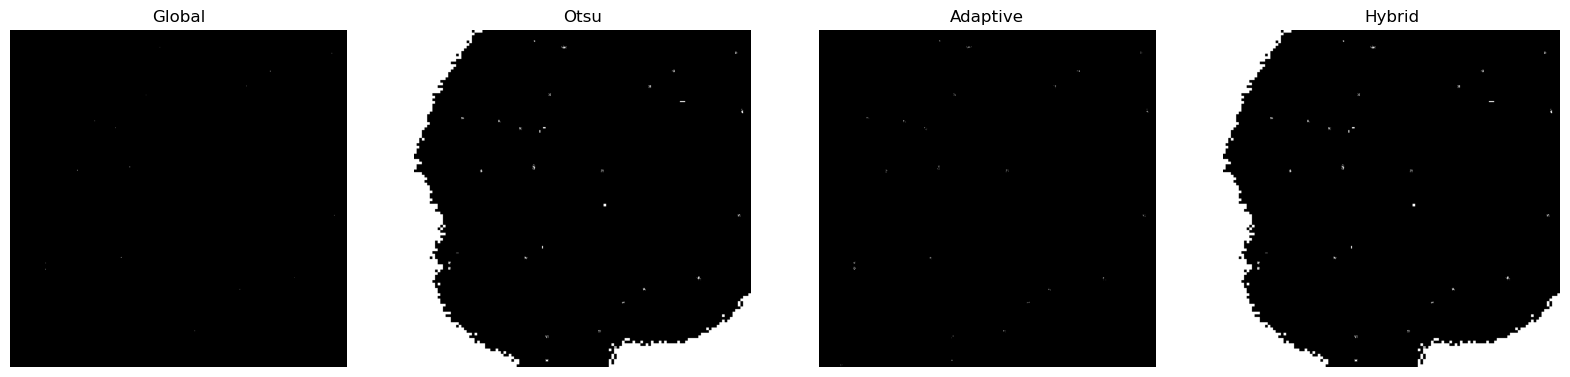

In [66]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def threshold(frame, method='otsu', global_thresh=50):
    # Check if the frame is grayscale
    if len(frame.shape) == 3:
        frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    if method == 'global':
        _, bw = cv.threshold(frame, global_thresh, 255, cv.THRESH_BINARY)
    elif method == 'otsu':
        _, bw = cv.threshold(frame, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    elif method == 'adaptive':
        bw = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, -2)
    elif method == 'hybrid':
        _, bw1 = cv.threshold(frame, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        bw2 = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, -2)
        bw = cv.bitwise_or(bw1, bw2)
    else:
        raise ValueError('Invalid thresholding method')
    
    return bw

# Function to display a montage of thresholded images
def display_thresholds(frame):
    methods = ['global', 'otsu', 'adaptive', 'hybrid']
    titles = ['Global', 'Otsu', 'Adaptive', 'Hybrid']
    global_thresh = 50

    fig, axes = plt.subplots(1, len(methods), figsize=(20, 5))
    
    for ax, method, title in zip(axes, methods, titles):
        img = threshold(frame, method=method, global_thresh=global_thresh)
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.show()


# Open the video file
video_file = "C:/Users/cameron schmidt/Desktop/PyProj/ExampleVideos/5X_-ph_9fps_Dil_1_50_Wash_R2_adj.avi"

cap = cv.VideoCapture(video_file)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Video not opened")
else:
    # Read the first frame
    ret, frame = cap.read()

    # Check if the frame was read successfully
    if ret:
        # Display the montage of thresholded images
        display_thresholds(frame)

    else:
        print("Error: Could not read frame.")

# Release the video capture object
cap.release()


## Centroid Detection by Morphology
Note: runs slowly. Accumulates processing time for each successive frame.

In [8]:
def loadVideo(videofile, as_gray=False, start_frame=0, end_frame=250):
    cap = cv.VideoCapture(videofile)
    frames = []
    current_frame = 0
    while True:
        ret, frame = cap.read()
        if not ret or (end_frame is not None and current_frame >= end_frame):
            break
        if current_frame >= start_frame:
            if as_gray:
                frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            frames.append(frame)
        current_frame += 1
    cap.release()
    frames = np.array(frames)
    return frames
    
#Centroid detection function
def determineCentroids_morphology(frames, kernel_size=(3,3)):

    # Make dataframe to store centroids
    f = pd.DataFrame(columns=['y', 'x', 'frame'])

    # Find centroids by focusing on heads
    for i in trange(len(frames)):
        frame = frames[i]

        # Find centroids by focusing on heads
        bw = threshold(frame, method='otsu')
        kernel = np.ones(kernel_size,np.uint8)
        bw = cv.morphologyEx(bw, cv.MORPH_OPEN, kernel)
        _, _, _, centroids = cv.connectedComponentsWithStats(bw, 4, cv.CV_32S) 

        # Filter out the background (always index 0)
        centroids = centroids[1:]

        # Add centroids to dataframe
        for centroid in centroids:
            f.loc[len(f.index)] = [centroid[1], centroid[0], i]

    return f
# Run the program
video = loadVideo('ExampleVideos/10X_HD_1024_R1.avi')
df_morph = determineCentroids_morphology(video)
df_morph.head()

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


,y,x,frame
0,0.500000,216.000000,0.0
1,0.500000,840.000000,0.0
2,1.285714,899.571429,0.0
3,6.540541,21.918919,0.0
4,8.000000,146.285714,0.0


## Binary File Saving Options

Save as human readable .csv, and binary parquet file - will save space for larger .csv's 

In [10]:
def save_dataframe(df, file_name_base):
    """
    Save a DataFrame as both .csv and .parquet files.

    Parameters:
    df (pd.DataFrame): The DataFrame to save.
    file_name_base (str): The base file name to use for saving (without extension).
    """
    # Save as CSV
    csv_file = f"{file_name_base}.csv"
    df.to_csv(csv_file, index=False)
    print(f"DataFrame saved as {csv_file}")

    # Save as Parquet
    # Note: Requires installation of the fastparquet pandas dependency
    parquet_file = f"{file_name_base}.parquet"
    df.to_parquet(parquet_file, index=False)
    print(f"DataFrame saved as {parquet_file}")

# Save the dataframe
save_dataframe(df_morph, '10X_-ph_9fps_R1')

DataFrame saved as 10X_-ph_9fps_R1.csv
DataFrame saved as 10X_-ph_9fps_R1.parquet


## Data Viz (xy histogram animation)
For simple visualization of output. Saves an mp4 video animation.

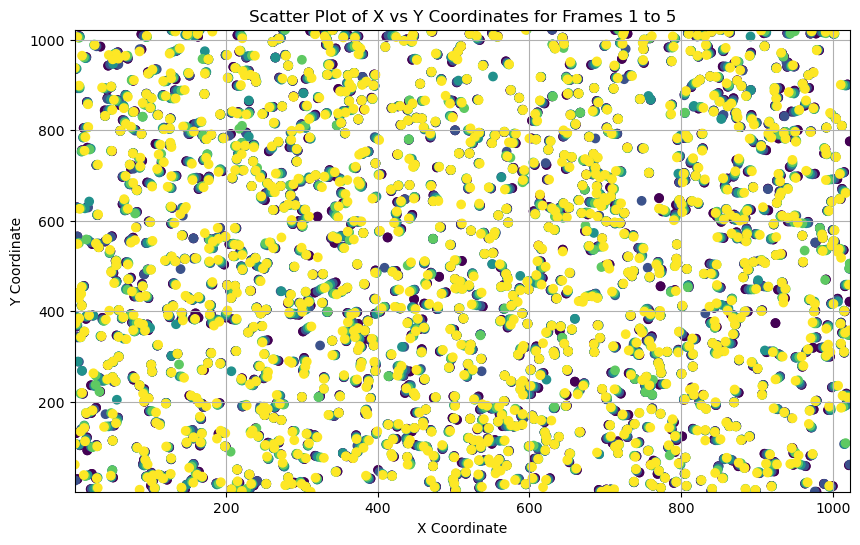

In [11]:
# Plot centroids over time and output .mp4 animation

parquet_file = '10X_HD_1024_R1.parquet'

# Read in the dataframe from the parquet file
df_centroids = pd.read_parquet(parquet_file)

# User-defined range of frames to plot
start_frame = 1
end_frame = 5

# Filter the dataframe for the user-defined range of frames
df_filtered = df_centroids[(df_centroids['frame'] >= start_frame) & (df_centroids['frame'] <= end_frame)]

# Create the animation
fig, ax = plt.subplots(figsize=(10, 6))
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(start_frame, end_frame)

def animate(frame):
    frame_data = df_filtered[df_filtered['frame'] == frame]
    colors = cmap(norm(frame_data['frame']))
    ax.scatter(frame_data['x'], frame_data['y'], c=colors, marker='o', label=f'Frame {frame}')
    ax.set_title(f'Scatter Plot of X vs Y Coordinates for Frames {start_frame} to {end_frame}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)
    ax.set_xlim(df_filtered['x'].min(), df_filtered['x'].max())
    ax.set_ylim(df_filtered['y'].min(), df_filtered['y'].max())

# Initialize the plot with no data
ax.set_title(f'Scatter Plot of X vs Y Coordinates for Frames {start_frame} to {end_frame}')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True)
ax.set_xlim(df_filtered['x'].min(), df_filtered['x'].max())
ax.set_ylim(df_filtered['y'].min(), df_filtered['y'].max())

# Make the animation
ani = animation.FuncAnimation(fig, animate, frames=range(start_frame, end_frame + 1), repeat=False)

# Save the animation as an MP4 file
ani.save('centroid_animation.mp4', writer='ffmpeg', fps=10)

plt.show()

## Sandbox for trackpy utils

[Documentation](https://soft-matter.github.io/trackpy/dev/index.html)

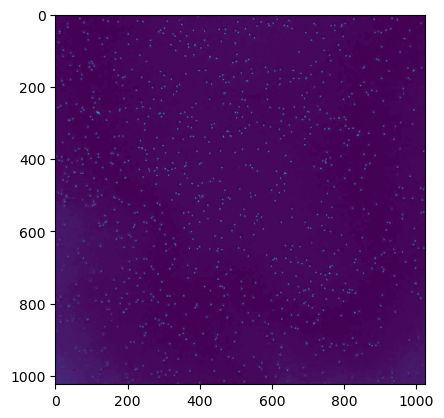

In [57]:
#Load the video (Utils)
# Load the video and save the first frame as a PNG
def loadVideo(videofile, as_gray=True):
    cap = cv.VideoCapture(videofile)
    frames = []
    first_frame_saved = False  # Indicator to ensure the first frame is saved only once
    while True:
        ret, frame = cap.read()
        if frame is None:
            break
        if as_gray:
            frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        frames.append(frame)
        # Save the first frame as PNG in the same directory as the video
        if not first_frame_saved:
            first_frame_path = os.path.splitext(videofile)[0] + '_first_frame.png'
            cv.imwrite(first_frame_path, frame)
            first_frame_saved = True
    cap.release()
    frames = np.array(frames)
    return frames

#Centroid detection function
def determineCentroids(frames, diameter=5, minmass=50, maxsize=10):
    f = tp.batch(frames, diameter=diameter, minmass=minmass, maxsize=maxsize)
    return f


# Run the program
video = loadVideo('C:/Users/cameron schmidt/Desktop/PyProj/ExampleVideos/5X_ph_9fps_wash_R1_first25_adj.avi')

plt.imshow(video[0])

Frame 24: 998 features


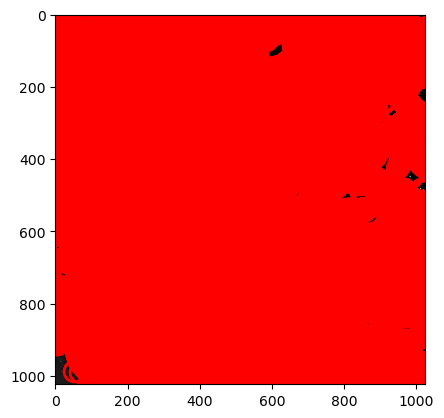

<AxesSubplot:>

In [58]:
df_track = determineCentroids(video)
df_track.head()
tp.annotate(df_track, video[0])

## Feed through the unified framework pipeline

In [ ]:
importlib.reload(tracker)
importlib.reload(utils)

frames = utils.loadVideo(videofile,as_gray=True)
f = tracker.determineCentroids(frames)
t = tracker.trackCentroids(f)

print(t.head())

In [ ]:
importlib.reload(tracker)

final = tracker.segmentCells(frames, t)

print(final.head())

In [ ]:
utils.saveDataFrame(final, videofile.split('.')[0] + '_tracked.csv')

### Feed through the statistics pipeline

In [4]:
importlib.reload(stats)

final_withstats = stats.calcAverageSpeed(final)

print(final_withstats.head())

In [ ]:
utils.saveDataFrame(final_withstats, videofile.split('.')[0] + '_tracked_withstats.csv')

### Use Visualizations

In [ ]:
importlib.reload(visualizer)

visualizer.runVisualization(videofile, final_withstats, visualization="segments")